In [69]:
from create_datasets import read_json_dataset
from dict_utils import unfold_to_list, fold_from_list
from pipeline import Pipeline, FewShotPipeline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,10)})
DIV_CMAP = sns.diverging_palette(220, 0, as_cmap=True) # DIVERGENT COLOR MAP

def add_lerc_preds(data, lerc_preds_dir, split):
    lerc_preds = read_json_dataset(lerc_preds_dir, split)
        
    for dataset, d in lerc_preds.items():
        for example_id, score in d.items():
            data[dataset][example_id]["LERC"] = (score["pred_score"] - 1) / (5-1)
            
    return data


def add_log(data, metrics):
    for m in metrics:
        data[f"{m}_log"] = data[m].apply(lambda s: np.log(s+1e-15)) 

In [79]:
train_df.columns

Index(['candidate', 'context', 'metadata', 'question', 'reference', 'score',
       'bleu1', 'bleu2', 'bleu3', 'bleu4', 'hf_bleu1', 'hf_bleu2', 'hf_bleu3',
       'hf_bleu4', 'rougeL', 'hf_rouge1', 'hf_rouge2', 'hf_rougeL',
       'hf_rougeLsum', 'meteor', 'recall', 'tp', 'fn', 'precision', 'fp',
       'f1_score', 'precision_at_err1', 'recall_at_err1', 'char_edit_score',
       'word_edit_score', 'sari_context', 'sari_question', 'bertscore',
       'bleurt', 'candidatelength_word', 'candidatelength_char',
       'candidatenunique_words', 'referencelength_word',
       'referencelength_char', 'referencenunique_words', 'contextlength_word',
       'contextlength_char', 'contextnunique_words', 'questionlength_word',
       'questionlength_char', 'questionnunique_words', 'dataset', 'example_id',
       'bleu1_log', 'bleu2_log', 'bleu3_log', 'bleu4_log', 'meteor_log'],
      dtype='object')

In [81]:
LOG_METRICS = [
    "bleu1",
    "bleu2",
    "bleu3",
    "bleu4",
    "meteor",
    'hf_rouge1',
    'hf_rouge2',
    "rougeL",
    "precision",
    "recall",
    "f1_score", 
    'precision_at_err1',
    'recall_at_err1'
]

LOG_METRICS_NAMES = [f"{m}_log" for m in LOG_METRICS]

In [82]:
DATASET_DIR = "../data/lr_experiments"
LERC_PREDS_DIR = f"{DATASET_DIR}/lerc_preds"

train = read_json_dataset(DATASET_DIR, "train_metrics")
dev = read_json_dataset(DATASET_DIR, "dev_metrics")
test = read_json_dataset(DATASET_DIR, "test_metrics")
print(len(train), len(dev), len(test))

add_lerc_preds(dev, LERC_PREDS_DIR, "dev")
add_lerc_preds(test, LERC_PREDS_DIR, "test")


train_df = pd.DataFrame(unfold_to_list(train, "dataset", "example_id"))
dev_df   = pd.DataFrame(unfold_to_list(dev, "dataset", "example_id"))
test_df  = pd.DataFrame(unfold_to_list(test, "dataset", "example_id"))
print(train_df.shape, dev_df.shape, test_df.shape)


if len(LOG_METRICS)>0:
    add_log(train_df, metrics=LOG_METRICS)
    add_log(dev_df, metrics=LOG_METRICS)
    add_log(test_df, metrics=LOG_METRICS)

train_df["score_scaled"] = train_df.score.apply(lambda s: (s-1)/(5-1))
dev_df["score_scaled"] = dev_df.score.apply(lambda s: (s-1)/(5-1))
test_df["score_scaled"] = test_df.score.apply(lambda s: (s-1)/(5-1))

6 6 6
(31069, 48) (4009, 49) (6321, 49)


In [83]:
DATASETS = list(train.keys())

METRICS = [
    # Bleu
    'bleu1', 'bleu2', 'bleu3', 'bleu4', 
    # 'hf_bleu1', 'hf_bleu2', 'hf_bleu3', 'hf_bleu4', 
    'rougeL', 
    # 'hf_rougeL', 'hf_rougeLsum',
    'hf_rouge1', 'hf_rouge2',
    'meteor',
    'recall', 'precision', 'f1_score',
    'sari_context', 'sari_question',
    # Token overlap when 1st error occurred
    'precision_at_err1', 'recall_at_err1',
    # Confusion matrix
    'tp', 'fn', 'fp',
    # Edit scores ------
    'char_edit_score', 'word_edit_score',
    # Learned metrics -------
    'bertscore', 'bleurt',
    # Input statistics ------
    'candidatelength_word', 'candidatelength_char',
    'candidatenunique_words', 'referencelength_word',
    'referencelength_char', 'referencenunique_words',
    'contextlength_word', 'contextlength_char',
    'contextnunique_words', 'questionlength_word',
    'questionlength_char', 'questionnunique_words',
]

TARGET = "score_scaled"

**Validate numbers reported in original MOCHA paper**

Most of the values are close to the numbers reported in the paper. The ones that are not, are consistently higher.

In [84]:
from scipy.stats import pearsonr

for dataset in DATASETS:
    print(); print("---- DEV SET ----")
    _df = dev_df[dev_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()
    
    print("TEST SET")
    _df = test_df[test_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()


---- DEV SET ----
cosmosqa bleu1 0.66
cosmosqa meteor 0.697
cosmosqa rougeL 0.702
cosmosqa bert-score 0.805

TEST SET
cosmosqa bleu1 0.671
cosmosqa meteor 0.712
cosmosqa rougeL 0.701
cosmosqa bert-score 0.78


---- DEV SET ----
drop bleu1 0.409
drop meteor 0.664
drop rougeL 0.48
drop bert-score 0.174

TEST SET
drop bleu1 0.388
drop meteor 0.568
drop rougeL 0.366
drop bert-score 0.329


---- DEV SET ----
mcscript bleu1 0.182
mcscript meteor 0.461
mcscript rougeL 0.225
mcscript bert-score 0.173

TEST SET
mcscript bleu1 0.261
mcscript meteor 0.503
mcscript rougeL 0.297
mcscript bert-score 0.195


---- DEV SET ----
narrativeqa bleu1 0.403
narrativeqa meteor 0.606
narrativeqa rougeL 0.434
narrativeqa bert-score 0.419

TEST SET
narrativeqa bleu1 0.472
narrativeqa meteor 0.616
narrativeqa rougeL 0.496
narrativeqa bert-score 0.535


---- DEV SET ----
quoref bleu1 0.675
quoref meteor 0.729
quoref rougeL 0.713
quoref bert-score 0.208

TEST SET
quoref bleu1 0.578
quoref meteor 0.716
quoref rouge

In [85]:
def get_subset(df, dataset = None, col="dataset"):
    return df[df[col] == dataset].copy() if dataset else df
    
def get_all_datasets(df, datasets, include_all=True):
    result = {} if not include_all else {"all": df.copy()}
    
    for dataset in datasets:
        result.update({dataset: get_subset(df, dataset)})
        
    return result

def get_loov_datasets(df, datasets):
    result = {}

    for dataset in datasets:
        loo_datasets = [get_subset(df, d) for d in datasets if d != dataset]
        loo_dataset = pd.concat(loo_datasets)
        
        result.update({f"except_{dataset}": loo_dataset})
        
    return result

TRAIN_DATASETS = get_all_datasets(train_df, DATASETS)
DEV_DATASETS   = get_all_datasets(dev_df, DATASETS)
TEST_DATASETS  = get_all_datasets(test_df, DATASETS)

TRAIN_LOO_DATASETS = get_loov_datasets(train_df, DATASETS)

# For baselines and individual metrics (and to avoid duplicating code)
# we may be interested in using "LERC" as a feature (e.g., baseline)
# To re-use the pipeline code, we will create a dummy variable with 
# LERC values of -1 for the dataset.
import copy
TRAIN_DATASETS_DUMMY_LERC = copy.deepcopy(TRAIN_DATASETS)

for dataset in TRAIN_DATASETS_DUMMY_LERC.values(): 
    dataset["LERC"] = -1
    
# Finally, we do a sanity check to ensure the original training set was
# not modified:
assert any("LERC" in d.columns for d in TRAIN_DATASETS.values()) == False

## Distributions

2277 (out of 4009) where rougeL values differ


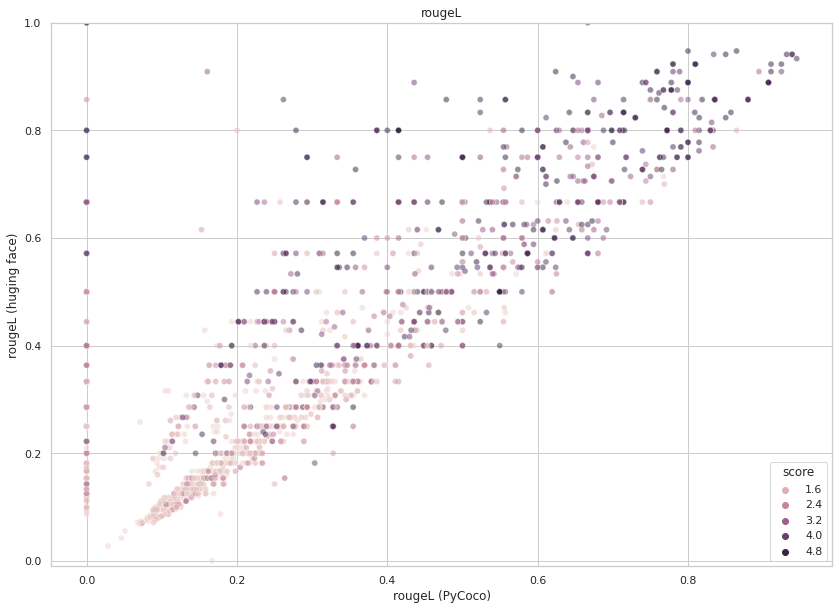

645 (out of 4009) where bleu1 values differ


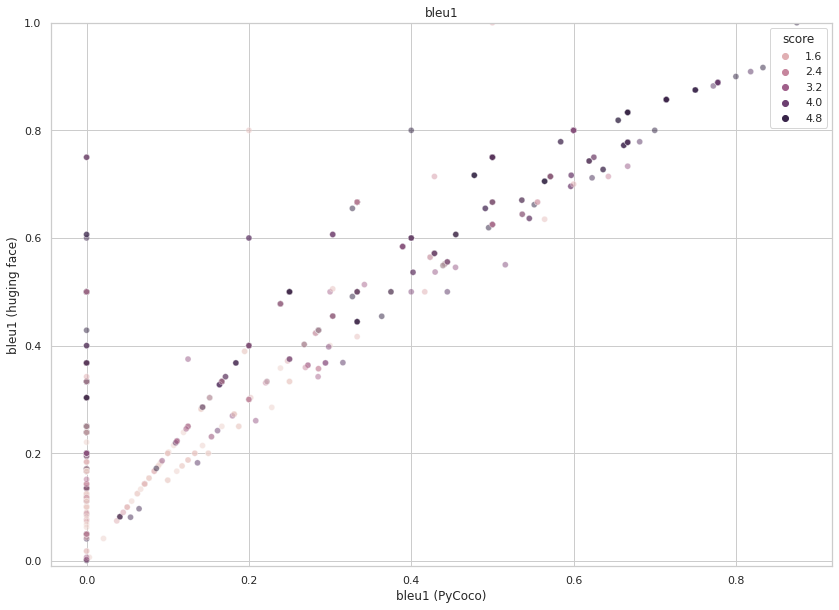

393 (out of 4009) where bleu2 values differ


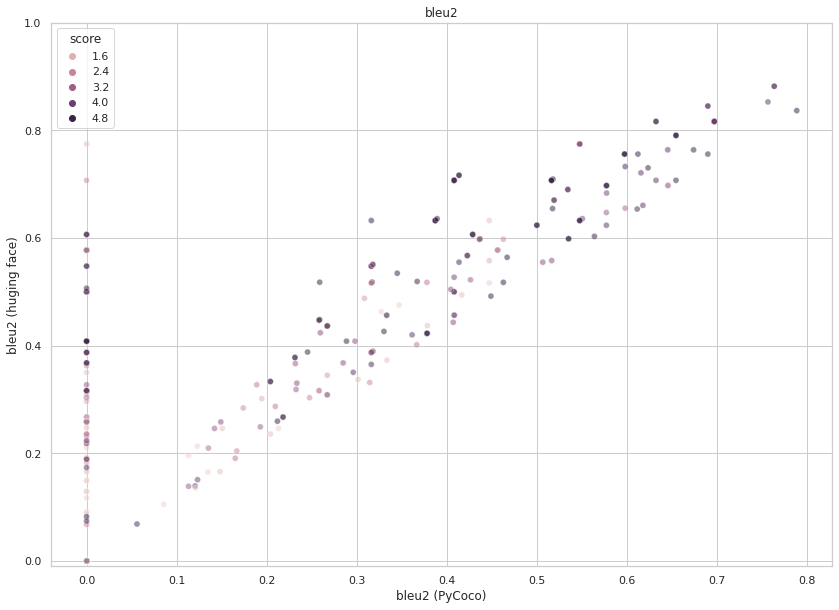

257 (out of 4009) where bleu3 values differ


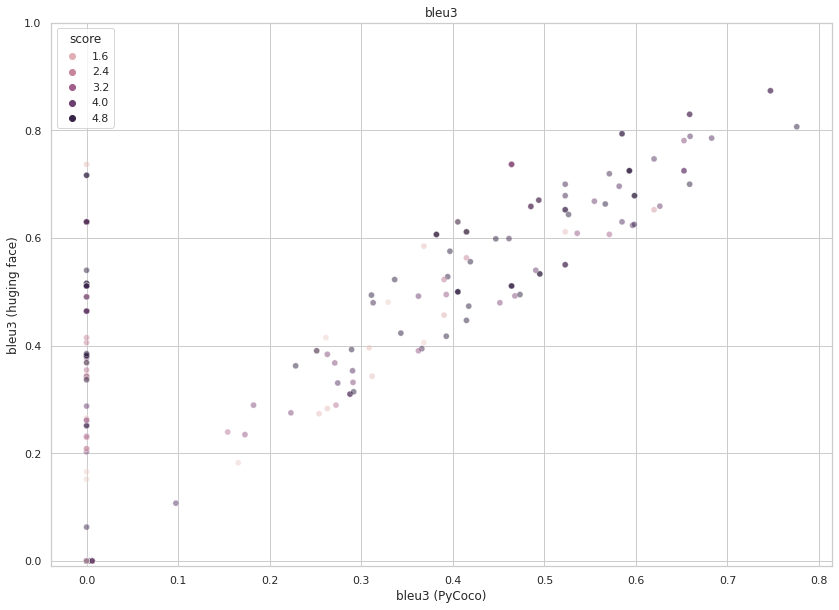

314 (out of 4009) where bleu4 values differ


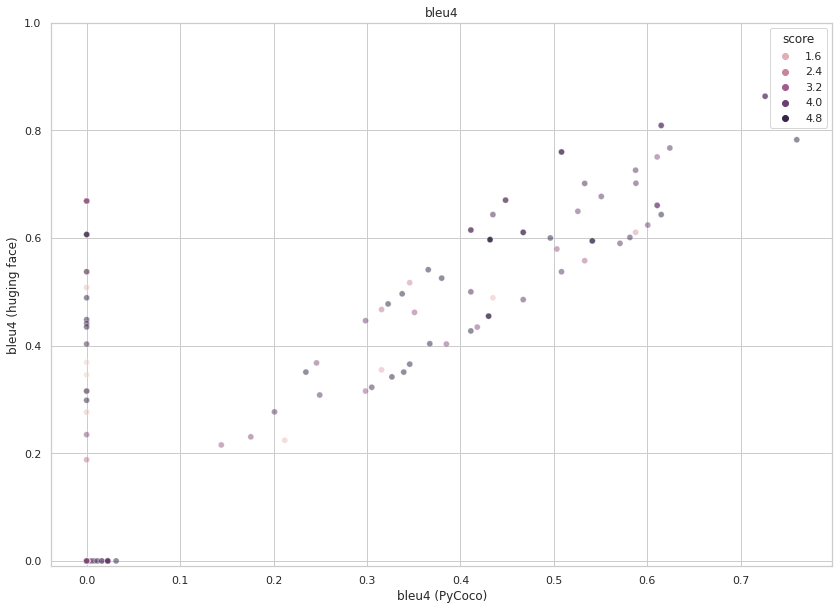

In [86]:
import json

diffs = {}
for metric in ("rougeL", "bleu1", "bleu2", "bleu3", "bleu4"):
    diff = dev_df[np.abs(dev_df[metric] - dev_df[f"hf_{metric}"]) > 1e-5]
    print(len(diff), f"(out of {len(dev_df)}) where {metric} values differ")
    
    diffs[metric] = {"n": len(dev_df), "n_differences": len(diff)}
    sns.scatterplot(data=diff, x=metric, y=f"hf_{metric}", hue="score", alpha=0.5)
    plt.xlabel(f"{metric} (PyCoco)")
    plt.ylabel(f"{metric} (huging face)")
    plt.title(metric)
    plt.ylim(-0.01, 1)
    plt.savefig(f"images/{metric}_implementation_diffs.png", dpi=200)
    plt.show()
    
with open("images/implementation_diffs.json", "w") as f:
    json.dump(diffs, f)

In [87]:
def plot_correlations(data, col, corr_method="pearson", figsize=(16, 12), **kwargs):
    plt.figure(figsize=figsize)
    sns.heatmap(data.corr(method=corr_method), vmin=-1, vmax=1, cmap=DIV_CMAP, annot=True, fmt=".2", **kwargs)
    plt.savefig(f"images/corr_{corr_method}_all_datasets.png", dpi=200)
    plt.show() 

    for val in data[col].unique():
        plt.figure(figsize=figsize)
        df = data[data[col] == val]
        sns.heatmap(df.corr(method=corr_method), vmin=-1, vmax=1, cmap=DIV_CMAP, annot=True, fmt=".2", **kwargs)
        plt.title(f"{col}={val}")
        plt.savefig(f"images/corr_{corr_method}_{val}.png", dpi=200)
        plt.show()

In [ ]:
plot_correlations(dev_df, "dataset", figsize=(30, 20))

In [ ]:
plot_correlations(dev_df, "dataset", corr_method="spearman", figsize=(30, 20))

### Distribution of Correctness

In [ ]:
data, split = train_df, "train"

fig, axes = plt.subplots(nrows=data.dataset.nunique(), ncols=3, figsize=(8, 15), tight_layout=True)

for i, dataset in enumerate(data.dataset.unique()):
    ax_pearson, ax_spearman, ax_correctness = axes[i, 0], axes[i, 1], axes[i, 2]
    df = data[data["dataset"] == dataset]
    df_features = df[METRICS]
    
    sns.heatmap(df_features.corr(method="pearson"), vmin=-1, vmax=1, cmap=DIV_CMAP, xticklabels=False, cbar=False, yticklabels=False,  ax=ax_pearson)
    ax_pearson.set_title(f"Pearson ({dataset})")
    
    sns.heatmap(df_features.corr(method="spearman"), vmin=-1, vmax=1, cmap=DIV_CMAP, xticklabels=False, cbar=False, yticklabels=False, ax=ax_spearman)
    ax_spearman.set_title(f"Spearman ({dataset})")
    
    ax_correctness.set_title(f"Distribution of correctness ({dataset})")
    sns.histplot(df, x=TARGET, ax=ax_correctness, bins=10, binrange=(0,1))
plt.savefig(f"images/dist_correctness_{split}.png", dpi=200)

In [ ]:
data = train_df
# How do these correlations change when we consider the subset of questions >= 2
fig, axes = plt.subplots(nrows=data.dataset.nunique(), ncols=3, figsize=(8, 15), tight_layout=True)

data = data[(data[TARGET] > 0.25)]# & (data[TARGET] <= 0.75)]
for i, dataset in enumerate(data.dataset.unique()):
    ax_pearson, ax_spearman, ax_correctness = axes[i, 0], axes[i, 1], axes[i, 2]
    df = data[data["dataset"] == dataset]
    df_features = df[METRICS]
    
    sns.heatmap(df_features.corr(method="pearson"), vmin=-1, vmax=1, cmap=DIV_CMAP, xticklabels=False, cbar=False, yticklabels=False,  ax=ax_pearson)
    ax_pearson.set_title(f"Pearson ({dataset})")
    
    sns.heatmap(df_features.corr(method="spearman"), vmin=-1, vmax=1, cmap=DIV_CMAP, xticklabels=False, cbar=False, yticklabels=False, ax=ax_spearman)
    ax_spearman.set_title(f"Spearman ({dataset})")
    
    ax_correctness.set_title(f"Distribution of correctness ({dataset})")
    sns.histplot(df, x=TARGET, ax=ax_correctness, bins=10, binrange=(0,1))

### Metrics distribution

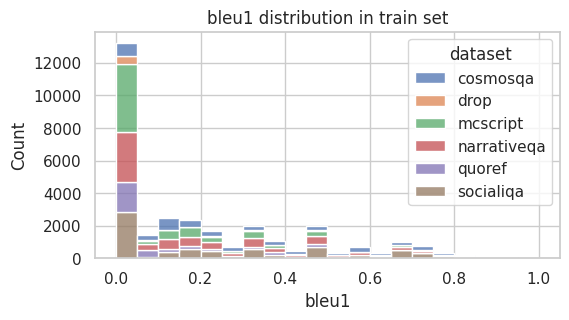

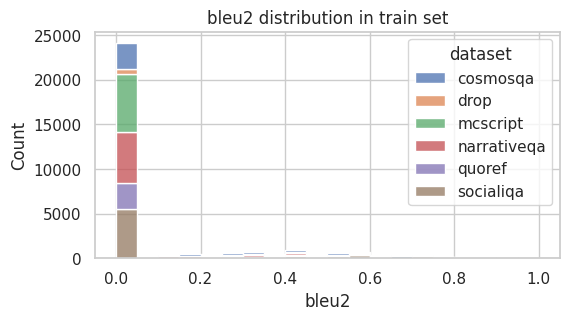

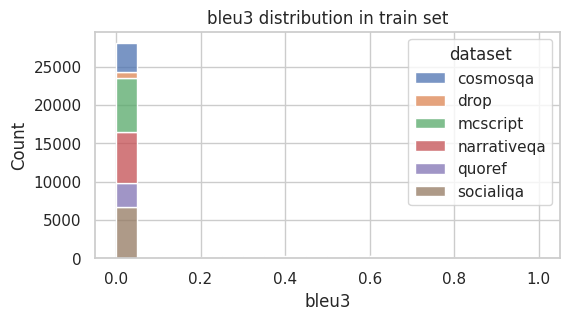

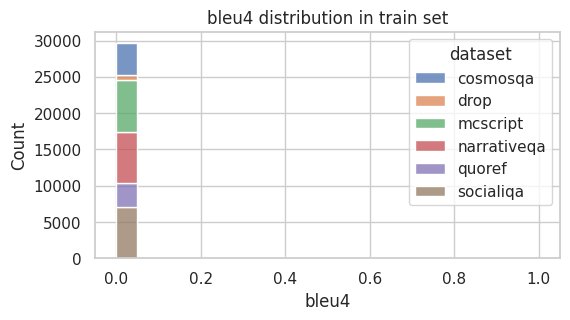

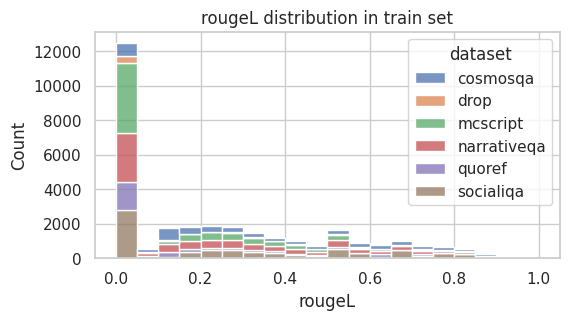

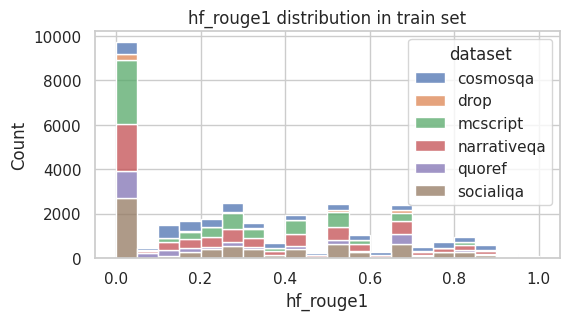

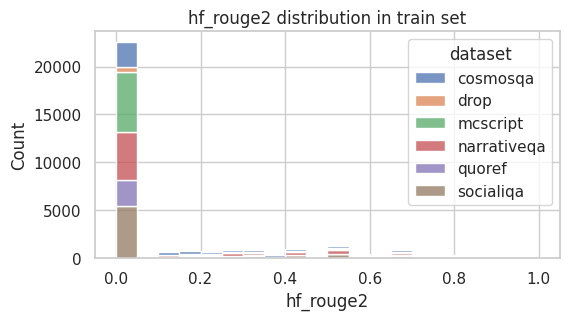

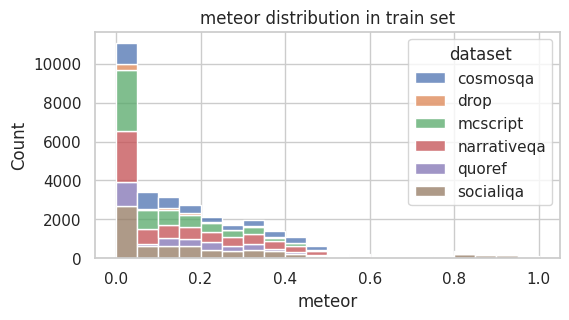

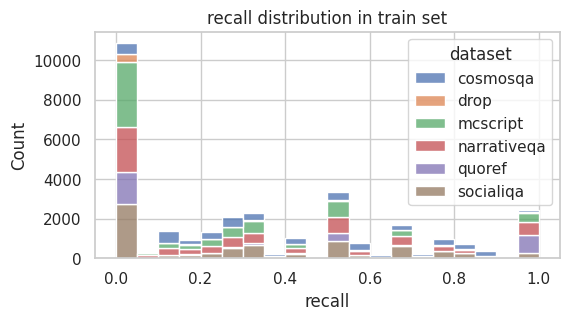

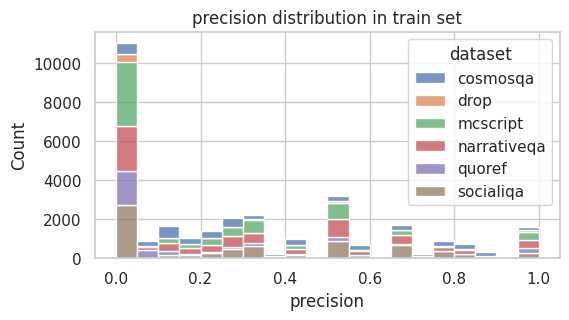

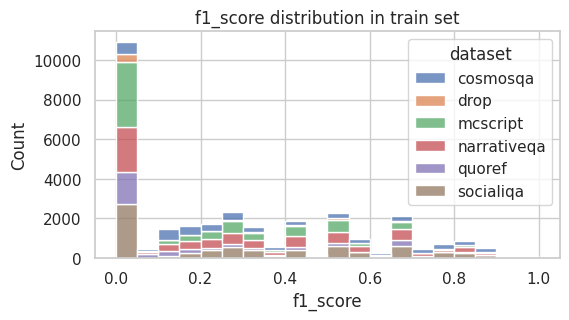

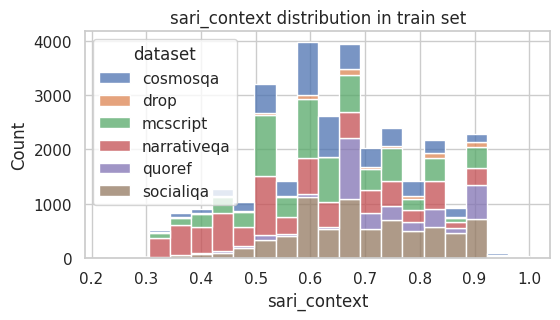

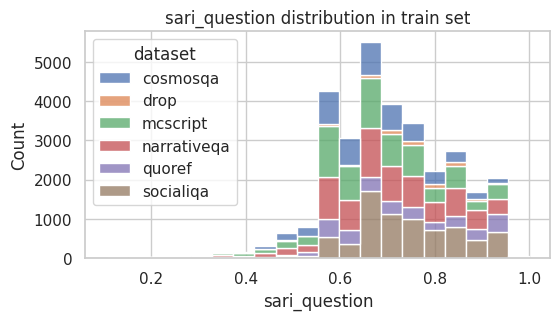

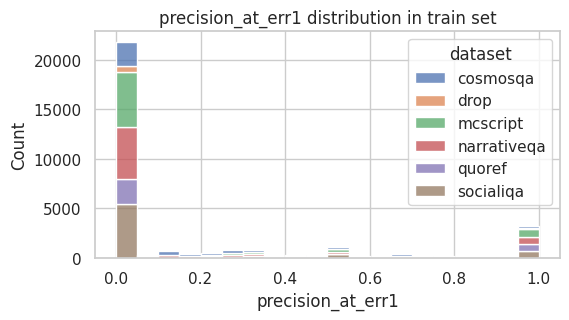

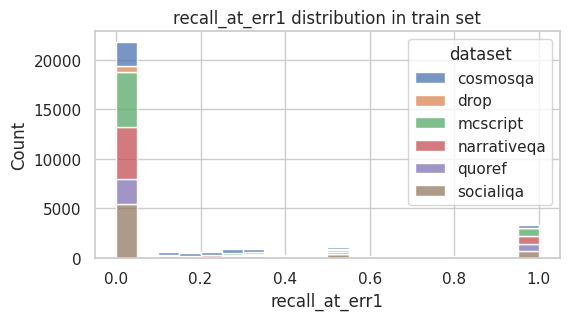

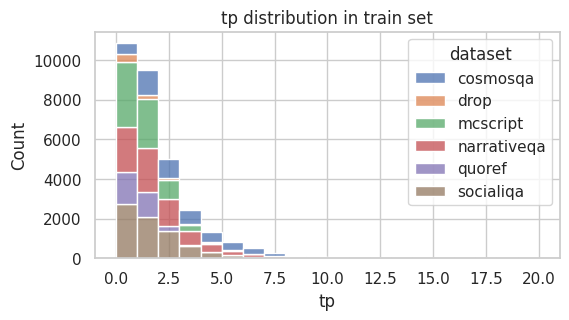

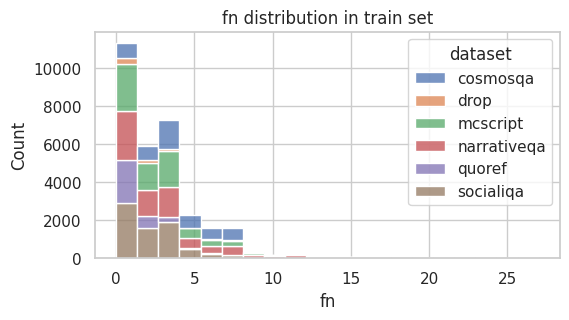

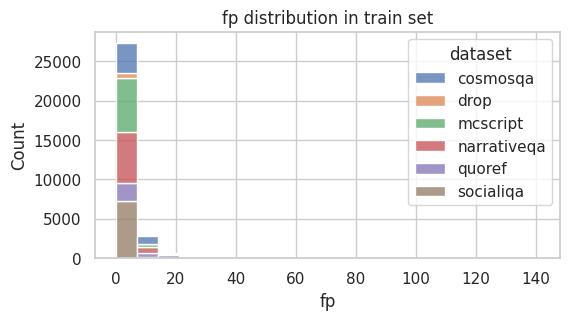

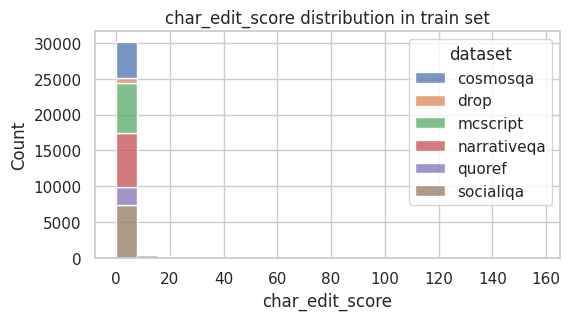

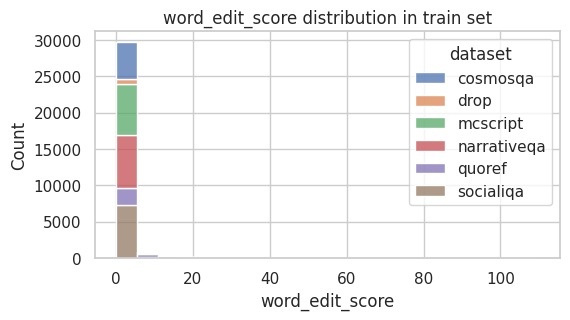

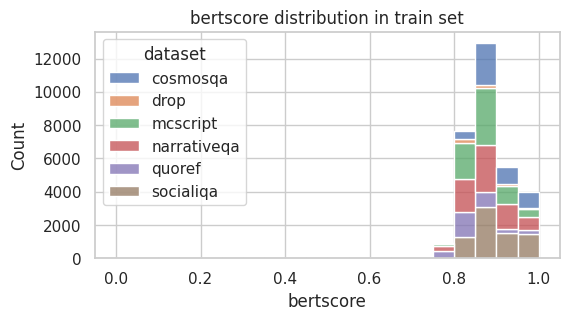

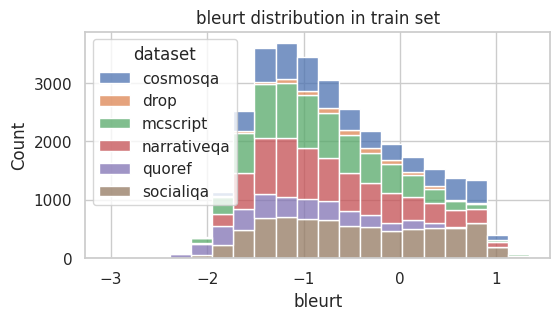

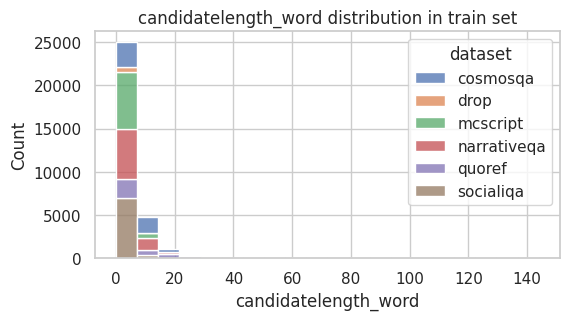

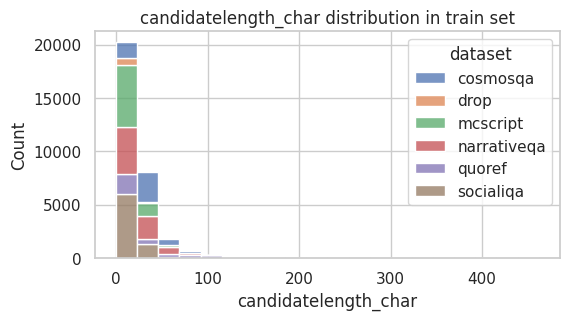

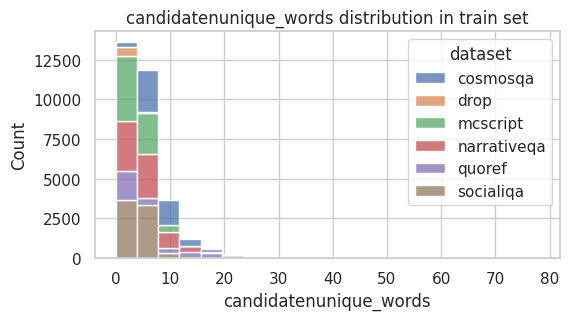

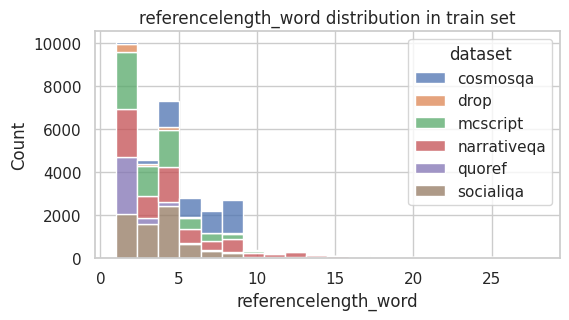

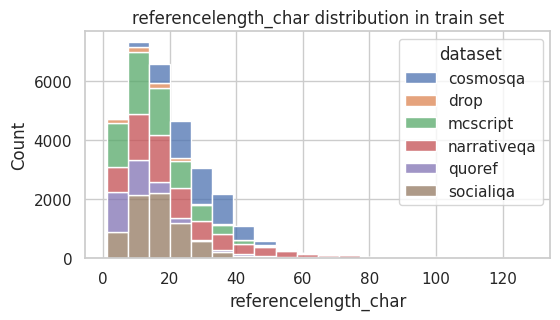

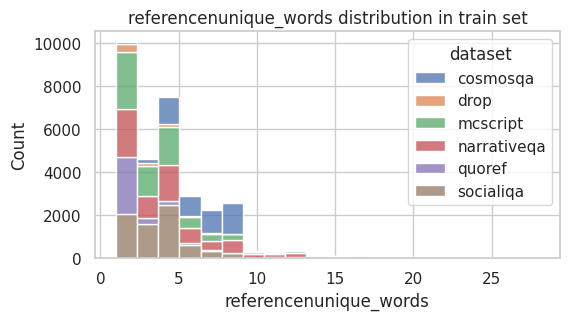

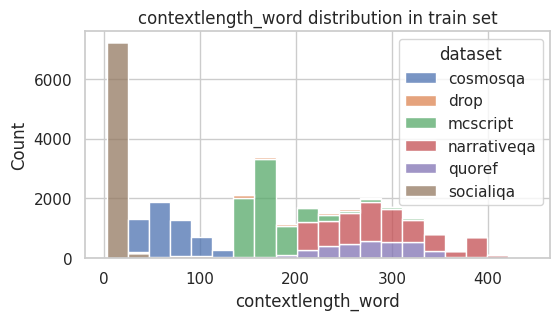

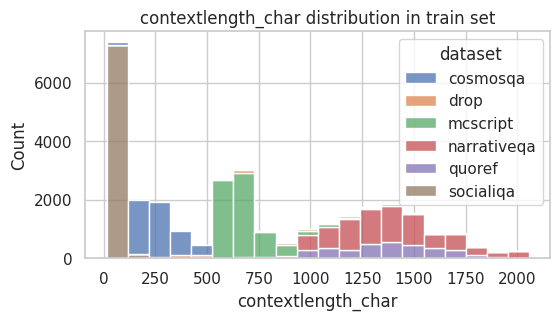

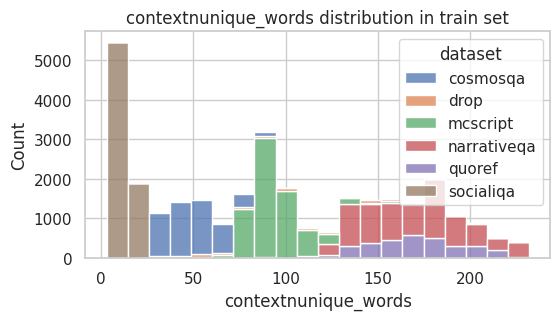

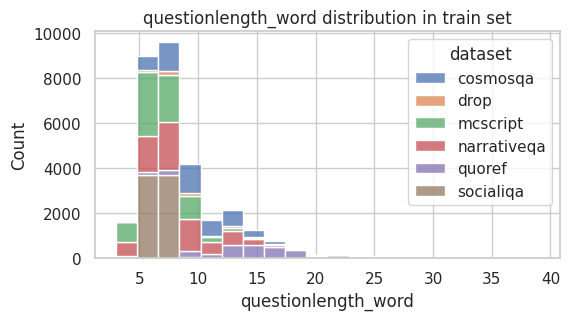

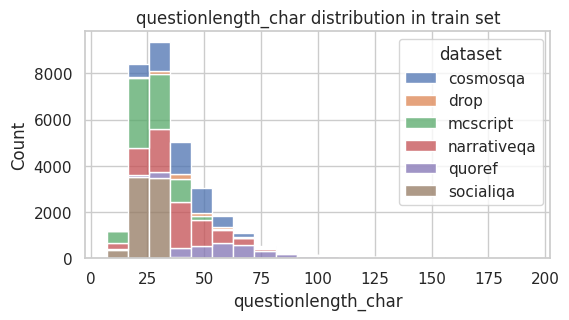

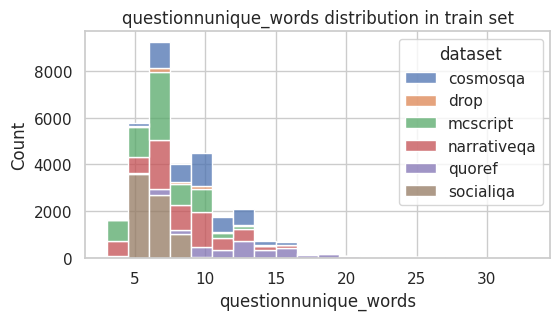

In [36]:
#data, split = dev_df.copy(), "dev"
data, split = train_df.copy(), "train"

for m in METRICS:
    plt.figure(figsize=(6, 3), dpi=100)
    sns.histplot(data=data, x=m, bins=20, label=m, hue="dataset", multiple="stack") # “dodge”, “stack”, “fill”}
    plt.title(f"{m} distribution in {split} set")
    plt.savefig(f"images/{m}_histplot_{split}_discriminated_by_dataset.png", dpi=100)
    plt.show()

In [35]:
data["candidatelength_word"].value_counts()

3      4709
1      4396
2      4384
4      3903
5      3149
6      2546
7      1924
8      1381
9      1051
10      730
11      565
12      423
13      338
14      310
15      251
16      192
17      155
19      148
18      122
20      106
23       53
22       51
24       47
21       47
25       27
27       12
26       12
28        7
50        3
30        2
31        2
29        2
35        2
36        2
38        1
96        1
76        1
0         1
87        1
39        1
61        1
78        1
58        1
80        1
77        1
49        1
144       1
32        1
111       1
67        1
34        1
Name: candidatelength_word, dtype: int64

#### Discriminate per dataset

In [ ]:
data, split = dev_df.copy(), "dev"
fig, axes = plt.subplots(len(METRICS), 6, figsize=(30, 120), tight_layout=True)

for i, m in enumerate(METRICS):
    for j, dataset in enumerate(DATASETS):
        d = data[data.dataset == dataset]
        
        ax = axes[i, j]
        sns.scatterplot(data=d, x=m, y=TARGET, ax=ax)

plt.savefig(f"images/metrics_distribution_{split}.png", dpi=300)

## Clustering

In [ ]:
# sns.pairplot(dev_df[METRICS +[TARGET]].head(10))

### UMAP 


[UMAP vs T-SNE comparison](https://blog.bioturing.com/2022/01/14/umap-vs-t-sne-single-cell-rna-seq-data-visualization/#:~:text=t%2DSNE%20and%20UMAP%20have,UMAP%20compresses%20that%20graph)
https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [ ]:
from sklearn.preprocessing import StandardScaler
import umap
reducer = umap.UMAP()

In [ ]:
dev_df_scaled = dev_df.copy()
dev_df_scaled[METRICS] = StandardScaler().fit_transform(dev_df_scaled[METRICS])
dev_df_scaled.head(2)

In [ ]:
embedding = reducer.fit_transform(dev_df_scaled[METRICS])
print(embedding.shape)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in dev_df_scaled.dataset.map({d: i for i, d in enumerate(DATASETS)})],
    alpha=0.5,
)
# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Metrics dataset', fontsize=24)

## Results analysis

In [ ]:
LERC_LOO_DEV = {
    "narrativeqa": 0.772,
    "mcscript": 0.666,
    "cosmosqa": 0.852,
    "socialiqa": 0.777,
    "drop": 0.760,
    "quoref": 0.704
}

LERC_AD_DEV = {
    "narrativeqa": 0.805,
    "mcscript": 0.816,
    "cosmosqa": 0.864,
    "socialiqa": 0.820,
    "drop": 0.796,
    "quoref": 0.794
}

LERC_LOO_TEST = {
    "narrativeqa": 0.738,
    "mcscript": 0.694,
    "cosmosqa": 0.824,
    "socialiqa": 0.760,
    "drop": 0.712,
    "quoref": 0.741
}

def get_evaluated_on(data, dataset):
    return data[data["evaluated_on"] == dataset]

In [ ]:
dataset = "cosmosqa"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_rfw_learned_metrics_1.csv", **read_csv_kwargs)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
dataset = "mcscript"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
dataset = "narrativeqa"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
dataset = "socialiqa"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}


read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
dataset = "drop"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
dataset = "quoref"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
# Lasso